In [84]:
import pandas as pd

#### Новости

In [85]:
news = pd.read_csv('/Users/ilburtsev/Documents/ML_business/data/materials.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


#### Загрузим ользователей и списки последних прочитанных новостей

In [86]:
users = pd.read_csv('/Users/ilburtsev/Documents/ML_business/data/users_articles.csv')
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


#### Нужно получить векторные представления пользователей на основе прочитанных ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [87]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [88]:
#предобработка текстов
import re
import numpy as np
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilburtsev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
stopwords_ru = stopwords.words('russian')
len(stopwords_ru)

morph = pymorphy2.MorphAnalyzer()

In [90]:
with open('/Users/ilburtsev/Documents/ML_business/data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopwords_ru += additional_stopwords
len(stopwords_ru)

777

In [91]:
def clean_text(text):
    '''
    очистка текста

    на выходе очищенный текст

    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", "", str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]

    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    леммитизация
        [0] если зашел тип не 'str' делаем его 'str'
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированных токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stopwords_ru] # [6]

    return words_lem_without_stopwords

In [92]:
%%time
# Запускаем очистку текста
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: total: 30.5 s
Wall time: 31.7 s


In [93]:
%%time
# Запускаем леммитизацию текста
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 3min 45s
Wall time: 3min 56s


### А теперь в 3 строчки обучим нашу модель

In [94]:
# сформируем список наших текстов, азбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [95]:
common_dictionary[1]

'алексей'

Все просто - это словарь наших слов

Запускаем обучение

In [96]:
topics_number = 20

In [97]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus
lda = LdaModel(common_corpus, num_topics=topics_number, id2word=common_dictionary)#, passes=10)

CPU times: total: 43.4 s
Wall time: 45.6 s


In [98]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath('model.lda')
lda.save(temp_file)

# Load a potentially pretrained model from disk
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:
    1. как выглядят наши темы
    2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [99]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.06297917),
 (3, 0.16951582),
 (5, 0.54116637),
 (6, 0.06956918),
 (8, 0.13997664)]

In [100]:
x = lda.show_topics(num_topics=topics_number, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below COde Prints Only Words
for topic, words in topics_words:
    print('topic_{}: '.format(topic)+' '.join(words))

topic_0: организм кость едва пищевой альянс коллекция приток
topic_1: журнал год писать рейс который город москва
topic_2: гражданин ракета год тело который миссия обнаружить
topic_3: год это новый университет двигатель который планета
topic_4: температура больной градус следователь сахар задержание вследствие
topic_5: исследование украина земля станция год украинский это
topic_6: восток египет производитель польский экскурсия японец тур
topic_7: президент который глава страна это сша человек
topic_8: это год который мочь свой всё весь
topic_9: поверхность космос земля депутат запуск объект сигнал
topic_10: высота арбитраж сергеев параметр воспаление бежать перевернуть
topic_11: фильм озеро кольцо техас артур дуга беларусь
topic_12: рак конкурс супруг достигать величина устанавливать сатурн
topic_13: дело суд газ ребёнок который сотрудник уголовный
topic_14: район произойти сша погибнуть который мозг результат
topic_15: год млн тыс составить место который самый
topic_16: осложнение уми

### Напишем функцию, которая будет нам возвращать векторное представление новостей

In [209]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(topics_number):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [210]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(topics_number)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(topics_number)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.070678,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.047388,0.000000,0.000000,0.0,0.860478,0.0,0.013829
1,4896,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.226582,0.579577,0.000000,...,0.0,0.0,0.056977,0.116846,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,4897,0.063958,0.0,0.0,0.169383,0.0,0.540882,0.069358,0.000000,0.139627,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,4898,0.070828,0.0,0.0,0.143443,0.0,0.000000,0.052314,0.000000,0.476596,...,0.0,0.0,0.000000,0.000000,0.216777,0.031558,0.0,0.000000,0.0,0.000000
4,4899,0.000000,0.0,0.0,0.000000,0.0,0.048935,0.241483,0.651387,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.035936


### Следующий шаг - векторные представления пользователей

In [211]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [212]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(topics_number)]].values))

In [213]:
doc_dict[293622]

array([0.        , 0.26069689, 0.13908552, 0.13604295, 0.04072548,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04378717, 0.08340227, 0.11087391,
       0.        , 0.        , 0.17613566, 0.        , 0.        ])

In [214]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [215]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.00739786, 0.00588269, 0.00331273,
       0.0122407 , 0.        , 0.16797997, 0.34434878, 0.03943031,
       0.        , 0.        , 0.        , 0.12790452, 0.03431231,
       0.04966139, 0.01804351, 0.16510791, 0.0055253 , 0.00717731])

In [216]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [217]:
' '.join(news[news['doc_id']==321961]['title'].iloc[0])

'россия похороны уго чавес представлять президент роснефть глава совет директор роснефтегаз игорь сечин ранг спецпредставитель президент россия министр промышленность торговля денис мантур гендиректор ростехнология сергей чемезов это сообщать риа новость ссылка пресссекретарить владимир путин дмитрий песков решение президент россия владимир путин российский сторона представить похороны президент венесуэла уго чавес игорь сечин статус спецпредставитель президент россия денис мантуров сопредседатель двусторонний межправкомиссия сергей чемезов сказать песок игорь сечин сергей чемезов неоднократно встречаться уго чавес различный переговоры чавес скончаться накануне военный госпиталь каракас двухлетний борьба онкологический заболевание похороны пройти пятница'

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [218]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(topics_number)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + ['topic_{}'.format(i) for i in range(topics_number)]]
user_embeddings.head(5)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.163261,0.042619,0.095812,0.006788,0.099278,0.010469,0.118805,0.146844,...,0.0,0.000000,0.015283,0.069003,0.050419,0.091478,0.000000,0.058083,0.000000,0.000000
1,u108690,0.000000,0.024551,0.016272,0.017201,0.000000,0.116836,0.001934,0.209159,0.288361,...,0.0,0.003014,0.001683,0.120355,0.037401,0.029664,0.000000,0.118013,0.000000,0.004593
2,u108339,0.000000,0.051500,0.072547,0.046341,0.003724,0.029899,0.000000,0.228553,0.187351,...,0.0,0.000000,0.000000,0.127529,0.113442,0.034818,0.014609,0.075585,0.000000,0.000000
3,u101138,0.061327,0.003906,0.007662,0.066166,0.000000,0.279180,0.080426,0.098235,0.232366,...,0.0,0.000000,0.000000,0.011082,0.017195,0.098915,0.000000,0.022794,0.000000,0.000000
4,u108248,0.000000,0.091962,0.055830,0.040264,0.012261,0.103318,0.001848,0.149068,0.326341,...,0.0,0.000000,0.000000,0.066159,0.044207,0.012124,0.000000,0.036849,0.007768,0.032992


Датасет готов - можно пробовать обучить модель. Загрузим нашу разметку

In [219]:
target = pd.read_csv('/Users/ilburtsev/Documents/ML_business/data/users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [220]:
X = pd.merge(user_embeddings, target, 'left')
X.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.163261,0.042619,0.095812,0.006788,0.099278,0.010469,0.118805,0.146844,...,0.000000,0.015283,0.069003,0.050419,0.091478,0.000000,0.058083,0.000000,0.000000,0
1,u108690,0.000000,0.024551,0.016272,0.017201,0.000000,0.116836,0.001934,0.209159,0.288361,...,0.003014,0.001683,0.120355,0.037401,0.029664,0.000000,0.118013,0.000000,0.004593,1
2,u108339,0.000000,0.051500,0.072547,0.046341,0.003724,0.029899,0.000000,0.228553,0.187351,...,0.000000,0.000000,0.127529,0.113442,0.034818,0.014609,0.075585,0.000000,0.000000,1
3,u101138,0.061327,0.003906,0.007662,0.066166,0.000000,0.279180,0.080426,0.098235,0.232366,...,0.000000,0.000000,0.011082,0.017195,0.098915,0.000000,0.022794,0.000000,0.000000,0
4,u108248,0.000000,0.091962,0.055830,0.040264,0.012261,0.103318,0.001848,0.149068,0.326341,...,0.000000,0.000000,0.066159,0.044207,0.012124,0.000000,0.036849,0.007768,0.032992,1


In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [222]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(topics_number)]],
                                                    X['churn'], random_state=17)

In [223]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [224]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.01353808, 0.05587623, 0.08391049, 0.08022059, 0.02886352,
       0.0163954 , 0.03750246, 0.03064612, 0.06672111, 0.01066054])

In [225]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Расчитаем Precision, Recall, F_score

In [226]:
precision_mean, recall_mean, thresholds = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_mean],
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best Threshold=0.253514, F-Score=0.658, Precision=0.588, Recall=0.747


In [227]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1658  101]
 [  80  161]]


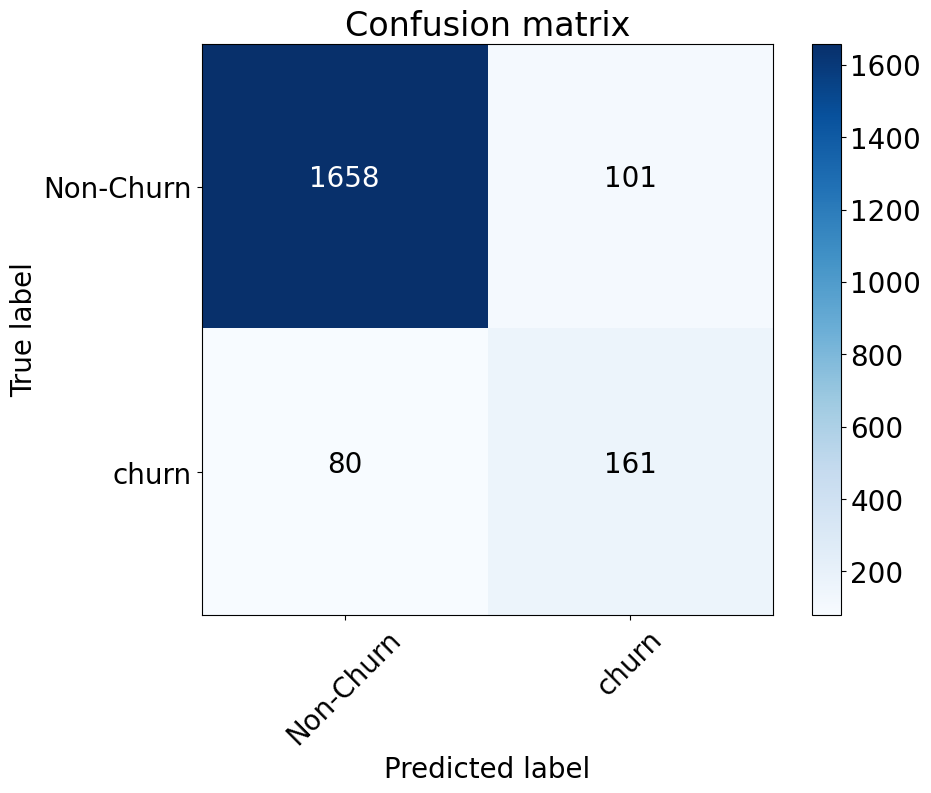

In [228]:
# мы уже нашли ранее 'оптимальный' порог, когда максимизировали f_score
font = {'size' : topics_number}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [236]:
mean_roc_auc = roc_auc_score(y_test, preds)
recall_mean_ = recall_mean[ix_mean]
precision_mean_ = precision_mean[ix_mean]
fscore_mean_ = fscore_mean[ix_mean]
precision_mean_

0.5882352941176471

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.

Функцию get_user_embedding посчитать медиану и попробовать порменить функцию max()

In [207]:
precision_median, recall_median, thresholds = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_median],
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.307739, F-Score=0.731, Precision=0.694, Recall=0.668


In [237]:
median_roc_auc = roc_auc_score(y_test, preds)
recall_median_ = recall_median[ix_median]
precision_median_ = precision_median[ix_median]
fscore_median_ = fscore_median[ix_median]
fscore_median_

0.7306835799859055

In [187]:
precision_max, recall_max, thresholds = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_max],
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.299717, F-Score=0.683, Precision=0.654, Recall=0.714


In [238]:
max_roc_auc = roc_auc_score(y_test, preds)
recall_max_ = recall_max[ix_max]
precision_max_ = precision_max[ix_max]
fscore_max_ = fscore_max[ix_max]
fscore_max_

0.6825396825396827

In [239]:
print(f'Mean - Precision: {precision_mean_}, Recall: {recall_mean_}, F-score: {fscore_mean_}, ROC_AUC: {mean_roc_auc}\nMedian - Precision: {precision_median_}, Recall: {recall_median_}, F-score: {fscore_median_}, ROC_AUC: {median_roc_auc}\nMax - Precision: {precision_max_}, Recall: {recall_max_}, F-score: {fscore_max_}, ROC_AUC: {max_roc_auc}')

Mean - Precision: 0.5882352941176471, Recall: 0.7468879668049793, F-score: 0.6581352833638024, ROC_AUC: 0.9417530235728995
Median - Precision: 0.6939655172413793, Recall: 0.6680497925311203, F-score: 0.7306835799859055, ROC_AUC: 0.9417530235728995
Max - Precision: 0.6539923954372624, Recall: 0.7136929460580913, F-score: 0.6825396825396827, ROC_AUC: 0.9417530235728995


Самый большой precision у метрики median, так-же значение recall довольно близко находится к precision - это значит, что данная модель работает лучше остальных. У данной модели наблюдается максимальный показатель fscore из имеющихся